<a href="https://colab.research.google.com/github/joyceee916/ATMS-597-SP-2020-Project-4/blob/master/Project4_Joyce_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
cd /content/drive/My Drive/ATMS 597/Project4

/content/drive/My Drive/ATMS 597/Project4


Importing KCMI Observational Data

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
KCMI_daily = pd.read_csv("KCMI_daily_format.csv", parse_dates=True, index_col='Date')
KCMI_daily.rename(columns={'TMAX(C)': 'TMAX_Obs', 'TMIN(C)': 'TMIN_Obs', 'WMAX(M/s)': 'WMAX_Obs', 'PREC(mm}': 'RTOT_Obs'}, inplace = True)
KCMI_daily.dropna(inplace=True)
KCMI_daily.index = KCMI_daily.index + pd.DateOffset(hours=12)  
KCMI_daily = KCMI_daily.rename_axis('Time')
KCMI_daily.head()

,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs
Time,,,,
2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0
2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0
2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0
2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0
2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0


GFS Daily Model 

In [7]:
GFS_daily = pd.read_csv("GFS_daily_2010_2019_test.csv", parse_dates=True, index_col='Time')
GFS_daily.drop(columns="Unnamed: 0", inplace=True)
GFS_daily.rename(columns={'TMAX': 'TMAX_GFS', 'TMIN': 'TMIN_GFS', 'WMAX': 'WMAX_GFS', 'RTOT': 'RTOT_GFS'}, inplace = True)
GFS_daily.dropna(inplace=True)
GFS_daily.head()

,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS
Time,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77


GFS Surface Data

In [0]:
GFS_surface = pd.read_csv("GFS_Sfc_new.csv", parse_dates=True, index_col='Time')
GFS_surface.rename(columns={'DWPC': 'DWPC_Surf', 'HCLD': 'HCLD_Surf', 'LCLD': 'LCLD_Surf', 'MCLD': 'MCLD_Surf',
                            'PRCP': 'PRCP_Surf', 'PRES': 'PRES_Surf', 'TMPC': 'TMPC_Surf', 'UWND': 'UWND_Surf',
                            'VWND': 'VWND_Surf', 'WSPD': 'WSPD_Surf'}, inplace = True)
GFS_surface.dropna(inplace=True)
GFS_surface.head(10)
GFS_surface.replace({9999.0: np.nan}, inplace=True)
GFS_surface.replace({-9999.0: np.nan}, inplace=True)

In [9]:
# shift data back 6 hours and resample by day 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = -6)
GFS_surface = GFS_surface.resample('24H').max()

# shift the data forward 12 hours for ease of merging with other datasets 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = 12)
GFS_surface.head(10)

,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf
Time,,,,,,,,,,
2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933
2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217
2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380
2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068
2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733
2010-01-07 12:00:00,-6.13,100.0,100.0,100.0,2.06,992.5,-5.46,5.3,2.4,6.888396
2010-01-08 12:00:00,-4.15,34.0,100.0,6.0,0.63,1000.0,-3.46,5.3,-2.0,8.645230
2010-01-09 12:00:00,-10.81,0.0,100.0,0.0,0.02,1004.9,-8.56,2.9,-2.4,4.441846
2010-01-10 12:00:00,-9.09,80.0,3.0,62.0,0.00,1005.7,-7.26,4.3,5.7,6.824954


GFS Profile Data

In [47]:
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    h = GFS_profile[var].str.strip('[|]|,').values
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_mean'
    GFS_profile[new_col_name]=list

GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').mean()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

,DWPC_925.0_mean,DWPC_850.0_mean,DWPC_700.0_mean,DWPC_500.0_mean,HGHT_925.0_mean,HGHT_850.0_mean,HGHT_700.0_mean,HGHT_500.0_mean,TMPC_925.0_mean,TMPC_850.0_mean,TMPC_700.0_mean,TMPC_500.0_mean,UWND_925.0_mean,UWND_850.0_mean,UWND_700.0_mean,UWND_500.0_mean,VWND_925.0_mean,VWND_850.0_mean,VWND_700.0_mean,VWND_500.0_mean
Time,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,-25.221669,-31.631814,-42.343174,-49.713078,820.874537,1458.322588,2924.016943,5404.973406,-17.736537,-15.005516,-16.276659,-26.871957,8.917408,11.668451,24.957946,49.957403,-18.631944,-22.035223,-36.006022,-53.129106
2010-01-03 12:00:00,-24.612461,-33.524255,-45.006084,-38.011418,825.026208,1466.561942,2943.248216,5429.166073,-14.528163,-13.728910,-14.633226,-28.177380,0.966968,2.928479,13.929298,34.531889,-8.503009,-12.642454,-22.324673,-29.460048
2010-01-04 12:00:00,-19.773137,-24.218344,-25.096941,-42.369095,808.518112,1455.589841,2932.208504,5390.650047,-13.448896,-11.433527,-16.459748,-31.019731,7.613226,6.086299,6.925063,7.042113,-18.257766,-18.436342,-22.440240,-22.675592
2010-01-05 12:00:00,-15.254223,-17.749616,-24.500529,-39.556158,796.682736,1446.840629,2934.372470,5413.979393,-12.478941,-9.982257,-14.372026,-29.423196,7.118404,5.853575,9.920349,12.764679,-15.989024,-18.744676,-22.421572,-19.083133
2010-01-06 12:00:00,-16.456283,-26.308794,-26.778580,-37.508100,787.429840,1442.774700,2938.356597,5443.111685,-9.918127,-8.066827,-13.002703,-26.093287,7.004508,9.396605,16.897229,30.434990,-6.298893,-7.324372,-8.470288,-15.845163


In [37]:
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)
h=GFS_profile.DWPC.str.strip('[|]|,').values

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_min'
    GFS_profile[new_col_name]=list
GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').min()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

,DWPC_925.0_min,DWPC_850.0_min,DWPC_700.0_min,DWPC_500.0_min,HGHT_925.0_min,HGHT_850.0_min,HGHT_700.0_min,HGHT_500.0_min,TMPC_925.0_min,TMPC_850.0_min,TMPC_700.0_min,TMPC_500.0_min,UWND_925.0_min,UWND_850.0_min,UWND_700.0_min,UWND_500.0_min,VWND_925.0_min,VWND_850.0_min,VWND_700.0_min,VWND_500.0_min
Time,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,-29.030483,-37.651972,-43.782516,-61.130393,-29.030483,-37.651972,-43.782516,-61.130393,-29.030483,-37.651972,-43.782516,-61.130393,-29.030483,-37.651972,-43.782516,-61.130393,-29.030483,-37.651972,-43.782516,-61.130393
2010-01-03 12:00:00,-28.167222,-37.752113,-54.588994,-44.951972,-28.167222,-37.752113,-54.588994,-44.951972,-28.167222,-37.752113,-54.588994,-44.951972,-28.167222,-37.752113,-54.588994,-44.951972,-28.167222,-37.752113,-54.588994,-44.951972
2010-01-04 12:00:00,-25.736667,-28.880000,-33.074543,-55.621521,-25.736667,-28.880000,-33.074543,-55.621521,-25.736667,-28.880000,-33.074543,-55.621521,-25.736667,-28.880000,-33.074543,-55.621521,-25.736667,-28.880000,-33.074543,-55.621521
2010-01-05 12:00:00,-16.711462,-27.261374,-32.457111,-49.697932,-16.711462,-27.261374,-32.457111,-49.697932,-16.711462,-27.261374,-32.457111,-49.697932,-16.711462,-27.261374,-32.457111,-49.697932,-16.711462,-27.261374,-32.457111,-49.697932
2010-01-06 12:00:00,-18.422791,-33.553223,-35.033016,-48.678754,-18.422791,-33.553223,-35.033016,-48.678754,-18.422791,-33.553223,-35.033016,-48.678754,-18.422791,-33.553223,-35.033016,-48.678754,-18.422791,-33.553223,-35.033016,-48.678754


Combine Datasets

In [48]:
# Combine GFS daily and KCMI daily
df1 = pd.merge(GFS_daily.reset_index(), KCMI_daily.reset_index(), on='Time', how='inner')
df1.Time = pd.to_datetime(df1.Time)
df1['Year'] = df1.Time.dt.year
df1['D_TMAX'] = df1['TMAX_GFS']-df1['TMAX_Obs']
df1['D_TMIN'] = df1['TMIN_GFS']-df1['TMIN_Obs']
df1['D_WMAX'] = df1['WMAX_GFS']-df1['WMAX_Obs']
df1['D_RTOT'] = df1['RTOT_GFS']-df1['RTOT_Obs']
df1

,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT
0,2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05,-11.111111,-16.666667,6.70560,0.0,2010,-0.148889,0.206667,0.618333,0.05
1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00
2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06
3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17
4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,2019-12-27 12:00:00,13.94,3.54,8.819297,2.73,6.111111,0.000000,6.70560,0.0,2019,7.828889,3.540000,2.113697,2.73
3572,2019-12-28 12:00:00,15.94,9.34,9.701546,11.58,13.333333,0.000000,10.28192,2.8,2019,2.606667,9.340000,-0.580374,8.78
3573,2019-12-29 12:00:00,7.24,-1.66,11.111256,2.57,15.000000,5.000000,10.28192,4.3,2019,-7.760000,-6.660000,0.829336,-1.73
3574,2019-12-30 12:00:00,-0.36,-2.26,8.769265,0.04,3.333333,-0.555556,11.62304,0.6,2019,-3.693333,-1.704444,-2.853775,-0.56


In [49]:
# Combine GFS Profile and GFS Surface 
df2 = pd.merge(GFS_surface.reset_index(), GFS_profile.reset_index(), on='Time', how='inner')
df2.Time = pd.to_datetime(df2.Time)
df2.head()

,Time,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0_mean,DWPC_850.0_mean,DWPC_700.0_mean,DWPC_500.0_mean,HGHT_925.0_mean,HGHT_850.0_mean,HGHT_700.0_mean,HGHT_500.0_mean,TMPC_925.0_mean,TMPC_850.0_mean,TMPC_700.0_mean,TMPC_500.0_mean,UWND_925.0_mean,UWND_850.0_mean,UWND_700.0_mean,UWND_500.0_mean,VWND_925.0_mean,VWND_850.0_mean,VWND_700.0_mean,VWND_500.0_mean
0,2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-25.221669,-31.631814,-42.343174,-49.713078,820.874537,1458.322588,2924.016943,5404.973406,-17.736537,-15.005516,-16.276659,-26.871957,8.917408,11.668451,24.957946,49.957403,-18.631944,-22.035223,-36.006022,-53.129106
1,2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-24.612461,-33.524255,-45.006084,-38.011418,825.026208,1466.561942,2943.248216,5429.166073,-14.528163,-13.728910,-14.633226,-28.177380,0.966968,2.928479,13.929298,34.531889,-8.503009,-12.642454,-22.324673,-29.460048
2,2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-19.773137,-24.218344,-25.096941,-42.369095,808.518112,1455.589841,2932.208504,5390.650047,-13.448896,-11.433527,-16.459748,-31.019731,7.613226,6.086299,6.925063,7.042113,-18.257766,-18.436342,-22.440240,-22.675592
3,2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-15.254223,-17.749616,-24.500529,-39.556158,796.682736,1446.840629,2934.372470,5413.979393,-12.478941,-9.982257,-14.372026,-29.423196,7.118404,5.853575,9.920349,12.764679,-15.989024,-18.744676,-22.421572,-19.083133
4,2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-16.456283,-26.308794,-26.778580,-37.508100,787.429840,1442.774700,2938.356597,5443.111685,-9.918127,-8.066827,-13.002703,-26.093287,7.004508,9.396605,16.897229,30.434990,-6.298893,-7.324372,-8.470288,-15.845163


In [50]:
# Combine two intermediate datasets into one feature matrix
features_df = pd.merge(df1.reset_index(), df2.reset_index(), on='Time', how='inner')
features_df.Time = pd.to_datetime(features_df.Time)
features_df.dropna(inplace=True)
features_df.head()

,index_x,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT,index_y,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0_mean,DWPC_850.0_mean,DWPC_700.0_mean,DWPC_500.0_mean,HGHT_925.0_mean,HGHT_850.0_mean,HGHT_700.0_mean,HGHT_500.0_mean,TMPC_925.0_mean,TMPC_850.0_mean,TMPC_700.0_mean,TMPC_500.0_mean,UWND_925.0_mean,UWND_850.0_mean,UWND_700.0_mean,UWND_500.0_mean,VWND_925.0_mean,VWND_850.0_mean,VWND_700.0_mean,VWND_500.0_mean
0,1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00,0,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-25.221669,-31.631814,-42.343174,-49.713078,820.874537,1458.322588,2924.016943,5404.973406,-17.736537,-15.005516,-16.276659,-26.871957,8.917408,11.668451,24.957946,49.957403,-18.631944,-22.035223,-36.006022,-53.129106
1,2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06,1,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-24.612461,-33.524255,-45.006084,-38.011418,825.026208,1466.561942,2943.248216,5429.166073,-14.528163,-13.728910,-14.633226,-28.177380,0.966968,2.928479,13.929298,34.531889,-8.503009,-12.642454,-22.324673,-29.460048
2,3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17,2,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-19.773137,-24.218344,-25.096941,-42.369095,808.518112,1455.589841,2932.208504,5390.650047,-13.448896,-11.433527,-16.459748,-31.019731,7.613226,6.086299,6.925063,7.042113,-18.257766,-18.436342,-22.440240,-22.675592
3,4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77,3,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-15.254223,-17.749616,-24.500529,-39.556158,796.682736,1446.840629,2934.372470,5413.979393,-12.478941,-9.982257,-14.372026,-29.423196,7.118404,5.853575,9.920349,12.764679,-15.989024,-18.744676,-22.421572,-19.083133
4,5,2010-01-06 12:00:00,-5.46,-7.46,9.548298,7.10,-7.777778,-19.444444,3.57632,1.5,2010,2.317778,11.984444,5.971978,5.60,4,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-16.456283,-26.308794,-26.778580,-37.508100,787.429840,1442.774700,2938.356597,5443.111685,-9.918127,-8.066827,-13.002703,-26.093287,7.004508,9.396605,16.897229,30.434990,-6.298893,-7.324372,-8.470288,-15.845163


In [0]:
# Split into training and test sets 
# Can change features 
x_train_all = features_df[features_df.Time.dt.year<2019]
x_test_all = features_df[features_df.Time.dt.year==2019]

y_train_all = features_df[features_df.Time.dt.year<2019]
y_test_all = features_df[features_df.Time.dt.year==2019]

Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt

**Linear Regression**

Max Temperature

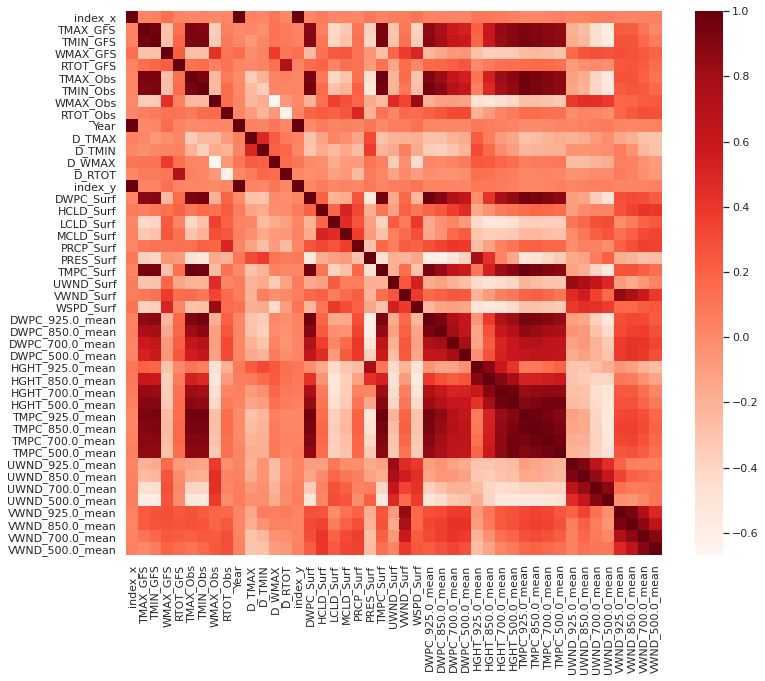

In [83]:
plt.figure(figsize=(12,10))
cor = features_df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [0]:
def lin_model_func(features, target):
    lin_model = LinearRegression()
    x_train = x_train_all[features]
    y_train = y_train_all[target]

    x_test = x_test_all[features]
    y_test = y_test_all[target]

    lin_model.fit(x_train, y_train)

    # Print parameters and plot - GFS Data
    print('Coefficients: \n', lin_model.coef_)
    print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, lin_model.predict(x_test))))

    print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

    return x_test, y_test, lin_model


Max Temperature

In [55]:
# Correlation with output variable 
cor_target = abs(cor['TMAX_Obs'])

relevant_features = cor_target[cor_target>0.80]
relevant_features

TMAX_GFS           0.933003
TMIN_GFS           0.930005
TMAX_Obs           1.000000
TMIN_Obs           0.942382
DWPC_Surf          0.933487
TMPC_Surf          0.983283
DWPC_925.0_mean    0.911464
DWPC_850.0_mean    0.816535
HGHT_700.0_mean    0.818610
HGHT_500.0_mean    0.879259
TMPC_925.0_mean    0.971571
TMPC_850.0_mean    0.938839
TMPC_700.0_mean    0.905802
TMPC_500.0_mean    0.871040
Name: TMAX_Obs, dtype: float64

In [56]:
features = ['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_mean', 'DWPC_850.0_mean', 'HGHT_700.0_mean', 'HGHT_500.0_mean', 'TMPC_925.0_mean', 'TMPC_850.0_mean', 'TMPC_700.0_mean', 'TMPC_500.0_mean']
target = ['TMAX_Obs']

x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[ 0.06356208 -0.00719723 -0.03300068  0.75188453  0.01353573 -0.06466799
   0.00923377 -0.0097145   0.42869968 -0.16414523  0.17844378 -0.03249324]]
The Mean Absolute Error: 1.46 degrees celsius
The Median Absolute Error: 1.11 degrees celsius
The Root Mean Square Error: 1.94 degrees celsius 
Coefficient of determination: 0.97


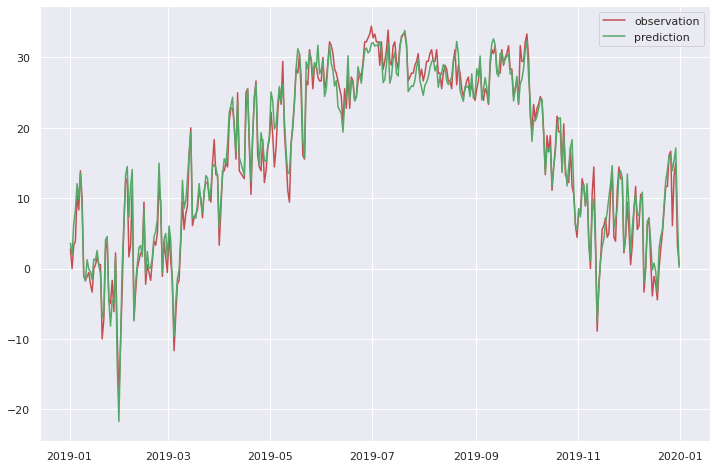

In [57]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, lin_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('linearregression.jpg')

Minimum Temperature

In [58]:
# Correlation with output variable 
cor_target = abs(cor['TMIN_Obs'])

relevant_features = cor_target[cor_target>0.80]
relevant_features

TMAX_GFS           0.911431
TMIN_GFS           0.927505
TMAX_Obs           0.942382
TMIN_Obs           1.000000
DWPC_Surf          0.950869
TMPC_Surf          0.954984
DWPC_925.0_mean    0.951571
DWPC_850.0_mean    0.876799
HGHT_500.0_mean    0.861173
TMPC_925.0_mean    0.961180
TMPC_850.0_mean    0.933953
TMPC_700.0_mean    0.902378
TMPC_500.0_mean    0.875814
Name: TMIN_Obs, dtype: float64

In [60]:
features = ['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_mean', 'DWPC_850.0_mean', 'HGHT_500.0_mean', 'TMPC_925.0_mean', 'TMPC_850.0_mean', 'TMPC_850.0_mean', 'TMPC_850.0_mean']
target = ['TMIN_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[-0.01235651  0.20687958  0.02221229  0.02509557  0.10888267  0.38872289
   0.00564638  0.00450103  0.3544268  -0.0713678  -0.0713678  -0.0713678 ]]
The Mean Absolute Error: 2.02 degrees celsius
The Median Absolute Error: 1.67 degrees celsius
The Root Mean Square Error: 2.65 degrees celsius 
Coefficient of determination: 0.94


Maximum Wind Speed

In [63]:
# Correlation with output variable 
cor_target = abs(cor['WMAX_Obs'])

relevant_features = cor_target[cor_target>0.4]
relevant_features

WMAX_GFS           0.436089
WMAX_Obs           1.000000
D_WMAX             0.667297
UWND_Surf          0.471663
WSPD_Surf          0.825205
HGHT_925.0_mean    0.463427
HGHT_850.0_mean    0.515283
HGHT_700.0_mean    0.457033
HGHT_500.0_mean    0.407652
UWND_850.0_mean    0.457213
UWND_700.0_mean    0.442003
Name: WMAX_Obs, dtype: float64

In [64]:
features = ['WMAX_GFS', 'WSPD_Surf', 'UWND_Surf', 'HGHT_925.0_mean', 'HGHT_850.0_mean', 'HGHT_700.0_mean', 'HGHT_500.0_mean', 'UWND_850.0_mean', 'UWND_700.0_mean']
target = ['WMAX_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[-0.0211839   0.94581271 -0.10180283 -0.01481979  0.00760428  0.00869
  -0.00621949  0.02589229  0.01521879]]
The Mean Absolute Error: 1.23 degrees celsius
The Median Absolute Error: 1.04 degrees celsius
The Root Mean Square Error: 1.59 degrees celsius 
Coefficient of determination: 0.72


Precipitation Accumulation

In [65]:
# Correlation with output variable 
cor_target = abs(cor['RTOT_Obs'])

relevant_features = cor_target[cor_target>0.26]
relevant_features

RTOT_Obs           1.000000
D_RTOT             0.610521
PRCP_Surf          0.502238
DWPC_700.0_mean    0.315449
DWPC_500.0_mean    0.305722
VWND_700.0_mean    0.293164
VWND_500.0_mean    0.280328
Name: RTOT_Obs, dtype: float64

In [66]:
features = ['PRCP_Surf', 'DWPC_700.0_mean', 'DWPC_500.0_mean', 'VWND_700.0_mean', 'VWND_500.0_mean']
target = ['RTOT_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Coefficients: 
 [[0.86962095 0.03777633 0.0492565  0.00913719 0.02546009]]
The Mean Absolute Error: 2.31 degrees celsius
The Median Absolute Error: 1.29 degrees celsius
The Root Mean Square Error: 3.97 degrees celsius 
Coefficient of determination: 0.38


**Random Forest**

In [0]:
# Create random forest regression model 
# some code adapted from (https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
from sklearn.ensemble import RandomForestRegressor 

In [0]:
# n_estimators and max_features can be lists 
def rf_model_func(features, target, n_estimators = 1000, max_features = 5):
    x_train = x_train_all[features]
    y_train = y_train_all[target]

    x_test = x_test_all[features]
    y_test = y_test_all[target]

    for n in n_estimators: 
        for m in max_features: 
            # Train the model 
            rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
            rf_model.fit(x_train, y_train)

            # Print parameters and plot
            print("# of trees =", n)
            print("Max features = ", m)
            print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
            print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
            print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
            print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

    print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))
    return x_test, y_test, rf_model

Maximum Temperature

In [78]:
features = ['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_mean', 'DWPC_850.0_mean', 'HGHT_700.0_mean', 'HGHT_500.0_mean', 'TMPC_925.0_mean', 'TMPC_850.0_mean', 'TMPC_700.0_mean', 'TMPC_500.0_mean']
target = ['TMAX_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [1000], max_features = [5]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 1000
Max features =  5
The Mean Absolute Error: 1.51 degrees celsius
The Median Absolute Error: 1.19 degrees celsius
The Root Mean Square Error: 1.98 degrees celsius 
Coefficient of determination: 0.97
[(0.4401, 'TMPC_Surf'), (0.2549, 'TMPC_925.0_mean'), (0.1029, 'TMIN_GFS'), (0.0982, 'TMPC_850.0_mean'), (0.0458, 'TMAX_GFS'), (0.0319, 'DWPC_Surf'), (0.008, 'TMPC_700.0_mean'), (0.0059, 'DWPC_925.0_mean'), (0.0039, 'HGHT_500.0_mean'), (0.0034, 'DWPC_850.0_mean'), (0.0026, 'HGHT_700.0_mean'), (0.0024, 'TMPC_500.0_mean')]


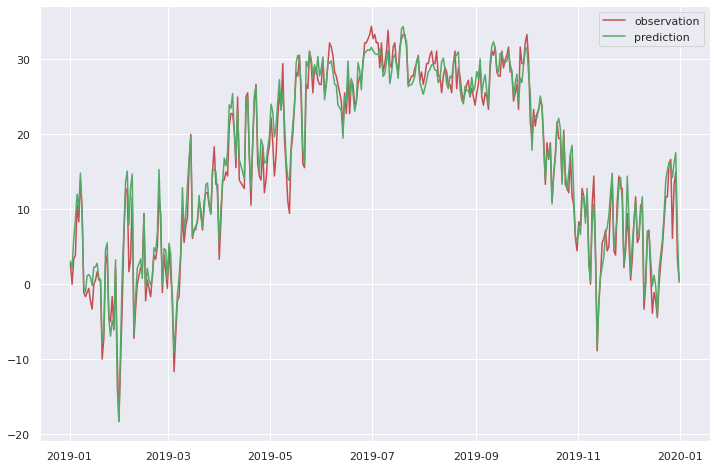

In [68]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, rf_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('randomforest.jpg')
plt.show()

Minimum Temperature

In [82]:
features = ['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_mean', 'DWPC_850.0_mean', 'HGHT_500.0_mean', 'TMPC_925.0_mean', 'TMPC_850.0_mean', 'TMPC_850.0_mean', 'TMPC_850.0_mean']
target = ['TMIN_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [1000], max_features = [5])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 1000
Max features =  5
The Mean Absolute Error: 1.80 degrees celsius
The Median Absolute Error: 1.42 degrees celsius
The Root Mean Square Error: 2.38 degrees celsius 
Coefficient of determination: 0.95
[(0.4114, 'TMPC_925.0_mean'), (0.2133, 'DWPC_925.0_mean'), (0.1995, 'TMPC_Surf'), (0.0761, 'DWPC_Surf'), (0.0228, 'TMPC_850.0_mean'), (0.0221, 'TMPC_850.0_mean'), (0.0195, 'TMPC_850.0_mean'), (0.0172, 'TMIN_GFS'), (0.0071, 'TMAX_GFS'), (0.0068, 'DWPC_850.0_mean'), (0.0043, 'HGHT_500.0_mean')]


Wind Speed

In [80]:
features = ['WMAX_GFS', 'WSPD_Surf', 'UWND_Surf', 'HGHT_925.0_mean', 'HGHT_850.0_mean', 'HGHT_700.0_mean', 'HGHT_500.0_mean', 'UWND_850.0_mean', 'UWND_700.0_mean']
target = ['WMAX_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [1000], max_features = [5])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 1000
Max features =  5
The Mean Absolute Error: 1.25 degrees celsius
The Median Absolute Error: 1.10 degrees celsius
The Root Mean Square Error: 1.59 degrees celsius 
Coefficient of determination: 0.72
[(0.554, 'WSPD_Surf'), (0.1354, 'UWND_850.0_mean'), (0.0728, 'UWND_Surf'), (0.0441, 'HGHT_850.0_mean'), (0.0424, 'WMAX_GFS'), (0.0398, 'HGHT_925.0_mean'), (0.0398, 'HGHT_500.0_mean'), (0.0392, 'UWND_700.0_mean'), (0.0325, 'HGHT_700.0_mean')]


Precipitation

In [81]:
features = ['PRCP_Surf', 'DWPC_700.0_mean', 'DWPC_500.0_mean', 'VWND_700.0_mean', 'VWND_500.0_mean']
target = ['RTOT_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [1000], max_features = [5])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 1000
Max features =  5
The Mean Absolute Error: 2.10 degrees celsius
The Median Absolute Error: 0.41 degrees celsius
The Root Mean Square Error: 4.27 degrees celsius 
Coefficient of determination: 0.28
[(0.4309, 'PRCP_Surf'), (0.1565, 'DWPC_500.0_mean'), (0.144, 'DWPC_700.0_mean'), (0.1423, 'VWND_500.0_mean'), (0.1263, 'VWND_700.0_mean')]
